In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd



In [ ]:
X, Y = make_classification(
    n_samples=1000, #total number of samples
    n_features=15, #total number of features
    n_classes=5, #number of classes
    n_clusters_per_class=1,#number of clusters per class
    n_redundant=0,#no redundant features
    n_informative=15,#all features are informative
    random_state=42#ensures reproducibility
)

print(f"Dataset shape: X={X.shape}, Y={Y.shape}")
print(f"First 10 labels: {Y[:10]}")

Dataset shape: X=(1000, 15), Y=(1000,)
First 10 labels: [0 3 2 2 1 1 1 4 4 4]


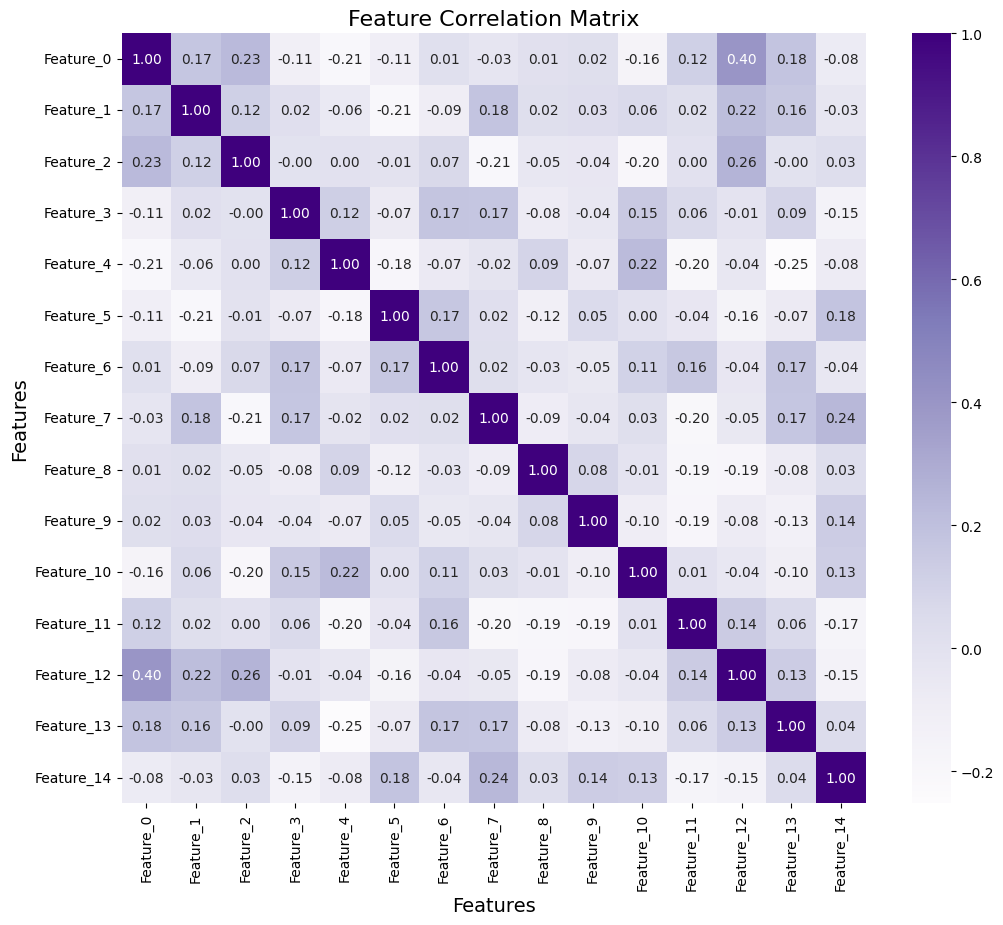

In [ ]:
# Make a DataFrame from X so it's easier to work with
# Name columns Feature_0, Feature_1, ... automatically
df = pd.DataFrame(X, columns=[f'Feature_{i}' for i in range(X.shape[1])])

# Check how all features relate to each other
corr = df.corr()

# Make the plot bigger so we can see everything
plt.figure(figsize=(12, 10))

# Draw a heatmap of the correlations
# Show numbers on it and use a purple color
sns.heatmap(corr, cmap='Purples', annot=True, fmt='.2f')

# Give the plot a title and label the axes
plt.title('Feature Correlation Matrix', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Features', fontsize=14)

# Show the plot
plt.show()



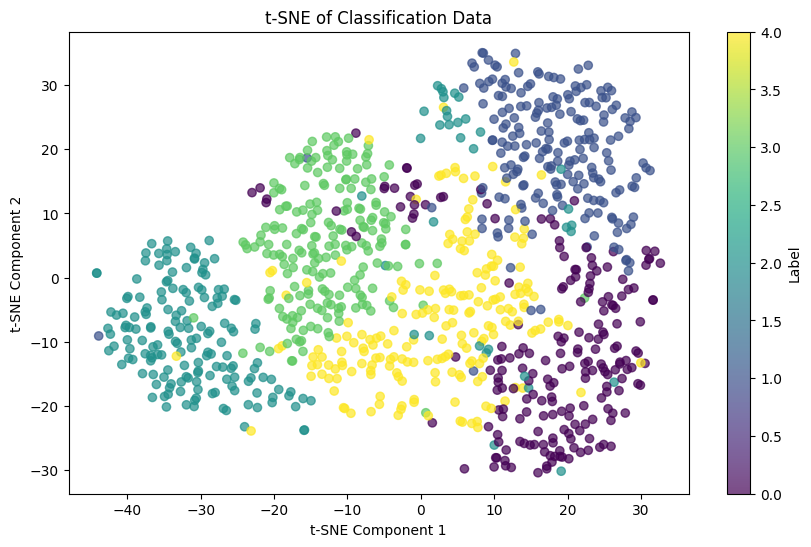

In [ ]:
# Reduce the high-dimensional data to 2D using t-SNE
# This helps us visualize the data easily
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Set up the plot size
plt.figure(figsize=(10, 6))

# Make a scatter plot of the 2D t-SNE results
# Color the points based on their class labels (Y)
# alpha=0.7 makes the points slightly transparent
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=Y, cmap='viridis', alpha=0.7)

# Add a colorbar to show which color corresponds to which label
plt.colorbar(label='Label')

# Label the axes
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

#  plot a title
plt.title('t-SNE of Classification Data')
plt.show()


In [ ]:
# Turn class labels into one-hot format
# This is needed for training a neural network
encoder = OneHotEncoder(sparse_output=False)
Y_encoded = encoder.fit_transform(Y.reshape(-1, 1))

# Check the new shape after one-hot encoding
print(f"One-hot encoded Y shape: {Y_encoded.shape}")

One-hot encoded Y shape: (1000, 5)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y_encoded, test_size=0.2, random_state=42
)


In [ ]:
class NeuralNetwork:
    def __init__(self):
        # Network architecture
        inputLayerNeurons = 15
        hiddenLayerNeurons1 = 64
        hiddenLayerNeurons2 = 32
        hiddenLayerNeurons3 = 16
        outLayerNeurons = 5  # Updated for 5 classes

        # Learning rate
        self.learning_rate = 0.01

        # Weight initialization
        self.W_H1 = np.random.randn(inputLayerNeurons, hiddenLayerNeurons1)
        self.W_H2 = np.random.randn(hiddenLayerNeurons1, hiddenLayerNeurons2)
        self.W_H3 = np.random.randn(hiddenLayerNeurons2, hiddenLayerNeurons3)
        self.W_O = np.random.randn(hiddenLayerNeurons3, outLayerNeurons)

    # Sigmoid activation for hidden layers
    # Formula: σ(x) = 1 / (1 + e^(-x))
    # Derivative for backprop: σ'(x) = σ(x) * (1 - σ(x))

    def sigmoid(self, x, der=False):
        if der:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))

    # Softmax activation for output layer
    # Converts logits to probabilities
    # Formula: softmax(x_i) = exp(x_i) / sum(exp(x_j))
    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)

    # Cross-entropy loss for multi-class classification
     # Formula: L = -1/m * Σ y_true * log(y_pred)
    def cross_entropy_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        log_likelihood = -np.log(y_pred[range(m), np.argmax(y_true, axis=1)])
        loss = np.sum(log_likelihood) / m
        return loss

    # Forward propagation
     # h1 = sigmoid(X·W_H1), h2 = sigmoid(h1·W_H2), ..., y_pred = softmax(h3·W_O)
    def feedForward(self, X):
        self.hidden_output1 = self.sigmoid(np.dot(X, self.W_H1))
        self.hidden_output2 = self.sigmoid(np.dot(self.hidden_output1, self.W_H2))
        self.hidden_output3 = self.sigmoid(np.dot(self.hidden_output2, self.W_H3))
        output_input = np.dot(self.hidden_output3, self.W_O)
        self.output = self.softmax(output_input)
        return self.output

    # Backpropagation
    # Update weights using gradient descent
    # ΔW = learning_rate * (input.T · δ), where δ = error * derivative
    def backPropagation(self, X, Y, pred):
        m = Y.shape[0]

        # Output layer error
        output_error = pred - Y
        output_delta = output_error / m

        # Hidden layer 3 error
        hidden_error3 = output_delta.dot(self.W_O.T)
        hidden_delta3 = hidden_error3 * self.sigmoid(self.hidden_output3, der=True)

        # Hidden layer 2 error
        hidden_error2 = hidden_delta3.dot(self.W_H3.T)
        hidden_delta2 = hidden_error2 * self.sigmoid(self.hidden_output2, der=True)

        # Hidden layer 1 error
        hidden_error1 = hidden_delta2.dot(self.W_H2.T)
        hidden_delta1 = hidden_error1 * self.sigmoid(self.hidden_output1, der=True)

        # Update weights
        self.W_O -= self.learning_rate * self.hidden_output3.T.dot(output_delta)
        self.W_H3 -= self.learning_rate * self.hidden_output2.T.dot(hidden_delta3)
        self.W_H2 -= self.learning_rate * self.hidden_output1.T.dot(hidden_delta2)
        self.W_H1 -= self.learning_rate * X.T.dot(hidden_delta1)

    # Training function
    def train(self, X, Y, epochs=20000):
        err_list = []
        for epoch in range(epochs):
            pred = self.feedForward(X)
            self.backPropagation(X, Y, pred)
            loss = self.cross_entropy_loss(Y, pred)
            if epoch % 1000 == 0:
                err_list.append(loss)
                print(f"Epoch {epoch}, Loss: {loss}")
        # Plot loss curve
        plt.figure(figsize=(8, 5))
        plt.plot(np.arange(0, epochs, 1000), err_list, marker='o')
        plt.title("Training Loss Curve")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.show()

    # Prediction
    def predict(self, X):
        pred = self.feedForward(X)
        return np.argmax(pred, axis=1)


Epoch 0, Loss: 4.720222355123071
Epoch 1000, Loss: 1.4206143446463677
Epoch 2000, Loss: 1.1920998704398136
Epoch 3000, Loss: 1.0177506932465241
Epoch 4000, Loss: 0.8911835451844025
Epoch 5000, Loss: 0.7919931478288944
Epoch 6000, Loss: 0.7095873849218982
Epoch 7000, Loss: 0.6411461776959411
Epoch 8000, Loss: 0.5844876271343095
Epoch 9000, Loss: 0.5370881716252788
Epoch 10000, Loss: 0.49665040818203354
Epoch 11000, Loss: 0.46186215955555676
Epoch 12000, Loss: 0.4315388355784931
Epoch 13000, Loss: 0.4044455931519384
Epoch 14000, Loss: 0.3798371878181595
Epoch 15000, Loss: 0.3574085560106014
Epoch 16000, Loss: 0.33690120328197865
Epoch 17000, Loss: 0.31801573194262495
Epoch 18000, Loss: 0.30045589675452256
Epoch 19000, Loss: 0.28396166566864567


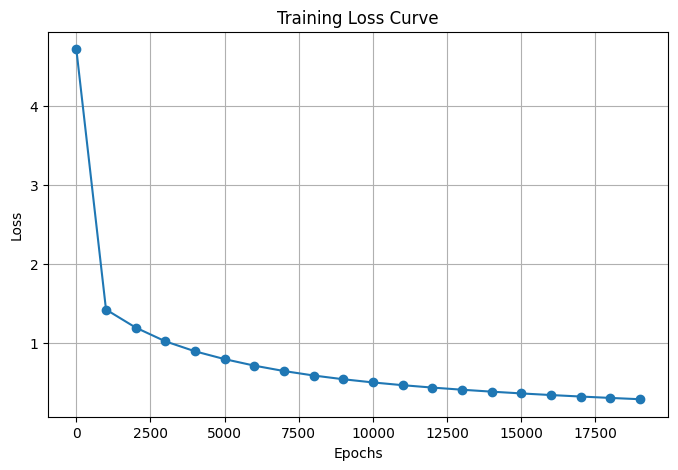

In [ ]:
# Create a neural network instance and train it on the training data
NN = NeuralNetwork()
NN.train(X_train, Y_train)


Training Accuracy: 0.94125
Test Accuracy: 0.8

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.80      0.76      0.78        46
           1       0.87      0.83      0.85        41
           2       0.68      0.90      0.78        31
           3       0.94      0.79      0.86        42
           4       0.73      0.75      0.74        40

    accuracy                           0.80       200
   macro avg       0.80      0.81      0.80       200
weighted avg       0.81      0.80      0.80       200



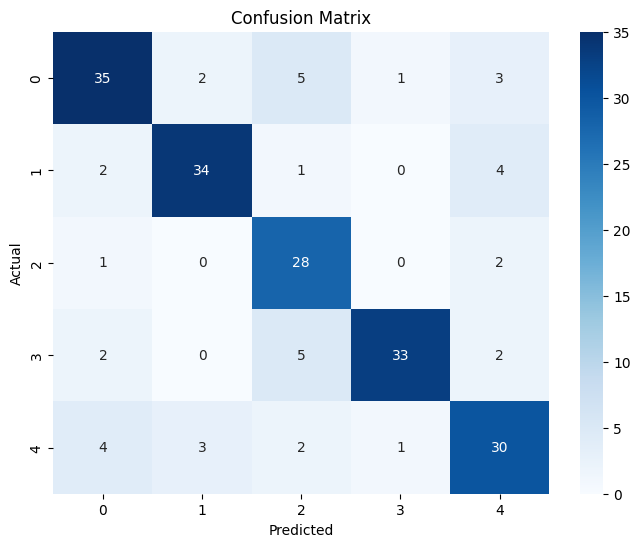


Predicted vs Actual Values (Test Set):
Predicted: 1, Actual: 1
Predicted: 2, Actual: 2
Predicted: 3, Actual: 3
Predicted: 2, Actual: 2
Predicted: 2, Actual: 2
Predicted: 4, Actual: 4
Predicted: 2, Actual: 2
Predicted: 3, Actual: 3
Predicted: 3, Actual: 3
Predicted: 4, Actual: 4


In [ ]:
train_predictions = NN.predict(X_train)
test_predictions = NN.predict(X_test)

# Convert one-hot Y back to class labels
Y_train_labels = np.argmax(Y_train, axis=1)
Y_test_labels = np.argmax(Y_test, axis=1)

# Accuracy
train_accuracy = accuracy_score(Y_train_labels, train_predictions)
test_accuracy = accuracy_score(Y_test_labels, test_predictions)
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Classification report
print("\nClassification Report (Test Set):")
print(classification_report(Y_test_labels, test_predictions))

# Confusion matrix
conf_mat = confusion_matrix(Y_test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Predicted vs Actual (first 10 samples)
print("\nPredicted vs Actual Values (Test Set):")
for i in range(10):
    print(f"Predicted: {test_predictions[i]}, Actual: {Y_test_labels[i]}")


**Implementation Details**

A three-hidden-layer neural network was implemented to classify a synthetic dataset with 1000 samples, 15 features, and 5 classes. Class labels were converted to one-hot vectors, hidden layers used sigmoid activation, and the output layer used softmax activation. The network was trained with cross-entropy loss and gradient descent (learning rate 0.01, 20,000 epochs).

**Challenges and Solutions:**
Several challenges were encountered during implementation. The original backpropagation assumed a binary output, so it was modified to correctly handle multi-class softmax outputs with one-hot labels. Network convergence was sensitive to weight initialization and learning rate, which was resolved by using np.random.randn for weights and setting a stable learning rate. Proper evaluation metrics were needed for multi-class performance, and accuracy, precision, recall, and F1-score from sklearn.metrics were used. Finally, visualizing high-dimensional decision boundaries for 5 classes was difficult, so t-SNE was applied to reduce the feature space to 2D for visualization of class separation.

**Results and Analysis**
The network achieved 94% training accuracy and 80% test accuracy. The confusion matrix and classification report showed that most classes were predicted correctly, with minor misclassifications. The training loss decreased steadily across epochs, demonstrating effective learning. t-SNE visualization confirmed reasonable separation of classes in 2D space. Testing different network configurations, such as increasing hidden layer sizes or adjusting learning rate, indicated that larger networks slightly improved test accuracy, while lower learning rates slowed convergence.

**Conclusion**

The network successfully learned complex patterns and classified the dataset effectively. Minor overfitting could be reduced using dropout or regularization. Future improvements include experimenting with different activation functions, larger datasets, or hyperparameter tuning.

